# Basic Workflow for Machine Learning
## By Jeff Hale

## Overview 

In this project I'm documenting a machine learning workflow for a supervised learning regression task in Python. In particular, we are predicting house property prices with the popular [Ames Housing Dataset](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf). 

We're going to try to minimize the RMSE. For the Kaggle competition associated with this exercise judges on the smallest Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. Smaller error = better model. We're not overly concerned with optimizing every bit of performance, but more with demonstrating the machine learning process for this type of project.

We'll explore the data, do some data cleaning, and some feature selection. We'll explore a variety of supervised machine learning algorithms including linear regression variants, nearest neighbors, SVMs, and gradient boosted regression trees. We'll use pipelines and grid searches to look for preprocessing steps, models, hyperparameters that work well.


More detailed plan:

- explore variables in Google Sheet
- display basic statistics
- visualize
- separate the validation data from the rest of the training data (the test data is already separated) 
- create a baseline model
- separate the data by datatype - interval, ordinal, and nominal
- drop values where it makes sense
- impute missing values
- encode nominal and ordinal data
- extract features
- search over preprocessing options, models, hyperparameters with pipelines
- explain along the way

## Explore variable data information
Write out the variables with definitions and thoughts in a google sheet. [Here's mine](https://docs.google.com/spreadsheets/d/106ZP2r97yRkkTbBqV9oEt00XNnjomhj3BvIaCNaeWlk/edit?usp=sharing) for this data set. This idea came from [ Pedro Marcelino's popular Kernel](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python).

This exercise was very valuable. Insights:
1. There are many features that could be very similar to each other. There's probably a lot of duplication of information in the variables (i.e. lots of correlatetion). We'll probably be selecting a limited number of features to make a better model.
2. A lot of variables in this data probably don't affect the price of housing much. We'll probably select a limited number of features to make a more parsimonious regression model. The size and condition of the home are likely to be important, but location may not be as important as in many cities. Ames, Iowa appears to be relatively homogeneous in terms of income and race, without wide differences of income and housing prices ([City Data](http://www.city-data.com/city/Ames-Iowa.html).  Ames had a population of 56,000 people in 2008 (the middle of the five year period for which housing prices were collected (US Census Bureau)) .
3. A *SaleType* of *COD* could be important because a *Court Officer Deed/Estate* would be expected to substantially reduce the sale price of a property.
4.  *SaleCondition* categories that aren't *Normal* could be predictive.
5. A good deal of the data is ordinal. Ordinal and nominal data will be one-hot encoded where appropriate.

## Setup
Let's import the libraries and methods we'll need and set some options to make data and charts display nicely.

In [1]:
# import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import xgboost as xgb

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,  cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, make_scorer

from IPython.display import HTML

import os
#print(os.listdir("../input"))

# configuration
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 80)

# reproducibility
np.random.seed(34) 

# silence warnings (works for sklearn conversions)
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# from [this](https://stackoverflow.com/a/43118091/4590385) SO question


List packages

In [2]:
!pip list

Package                            Version   
---------------------------------- ----------
absl-py                            0.6.1     
alabaster                          0.7.12    
anaconda-client                    1.7.2     
anaconda-navigator                 1.9.2     
anaconda-project                   0.8.2     
appdirs                            1.4.3     
appnope                            0.1.0     
appscript                          1.0.1     
args                               0.1.0     
arrow                              0.12.1    
asn1crypto                         0.24.0    
astor                              0.7.1     
astroid                            2.0.4     
astropy                            3.0.4     
atomicwrites                       1.2.1     
attrs                              18.2.0    
Automat                            0.7.0     
awscli                             1.16.47   
Babel                              2.6.0     
backcall                          

## Preliminarily data investigation
Load the data.

In [3]:
# load the data
# train_data = pd.read_csv("../input/train.csv")   # for Kaggle
train_data = pd.read_csv('../ames_housing_regression/data/train.csv')  # for local development

Run descriptive methods to get a better feel for the data.

In [4]:
train_data.shape

(1460, 81)

In [5]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,"1,460.00","1,460.00","1,201.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,452.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,379.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00","1,460.00"
mean,730.50,56.90,70.05,"10,516.83",6.10,5.58,"1,971.27","1,984.87",103.69,443.64,46.55,567.24,"1,057.43","1,162.63",346.99,5.84,"1,515.46",0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,"1,978.51",1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,"2,007.82","180,921.20"
std,421.61,42.30,24.28,"9,981.26",1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,"79,442.50"
min,1.00,20.00,21.00,"1,300.00",1.00,1.00,"1,872.00","1,950.00",0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,"1,900.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,"2,006.00","34,900.00"
25%,365.75,20.00,59.00,"7,553.50",5.00,5.00,"1,954.00","1,967.00",0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,"1,129.50",0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,"1,961.00",1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,"2,007.00","129,975.00"
50%,730.50,50.00,69.00,"9,478.50",6.00,5.00,"1,973.00","1,994.00",0.00,383.50,0.00,477.50,991.50,"1,087.00",0.00,0.00,"1,464.00",0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,"1,980.00",2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,"2,008.00","163,000.00"
75%,"1,095.25",70.00,80.00,"11,601.50",7.00,6.00,"2,000.00","2,004.00",166.00,712.25,0.00,808.00,"1,298.25","1,391.25",728.00,0.00,"1,776.75",1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,"2,002.00",2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,"2,009.00","214,000.00"
max,"1,460.00",190.00,313.00,"215,245.00",10.00,9.00,"2,010.00","2,010.00","1,600.00","5,644.00","1,474.00","2,336.00","6,110.00","4,692.00","2,065.00",572.00,"5,642.00",3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,"2,010.00",4.00,"1,418.00",857.00,547.00,552.00,508.00,480.00,738.00,"15,500.00",12.00,"2,010.00","755,000.00"


In [6]:
train_data.isnull().sum().head()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
dtype: int64

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [8]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.00",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.00",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.00",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.00",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.00",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
train_data.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.00,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,"1,999.00",RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.00,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.00,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,"1,978.00",Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.00,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.00,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,"1,941.00",RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.00,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,"1,950.00",Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.00,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,"1,965.00",Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


## Basic data visualization 
Let's visualize some data!

Let's look at a handful of variables that are likely to be important for predicting sale prices.

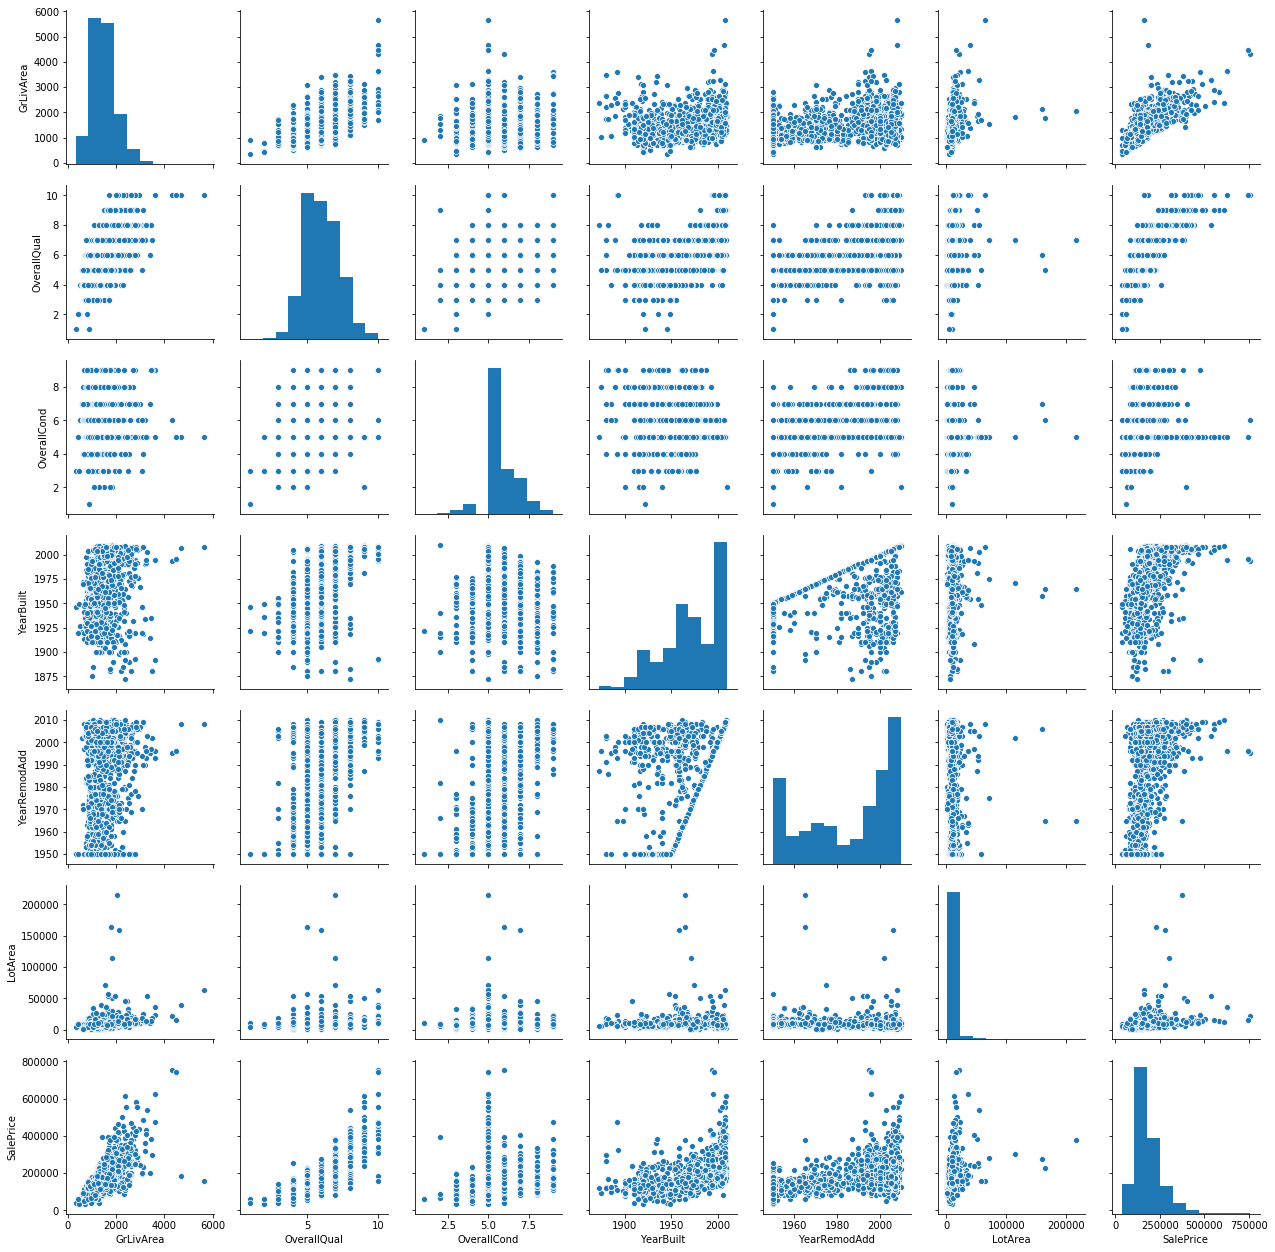

In [10]:
six_cols = ['GrLivArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'LotArea', 'SalePrice']
sns.pairplot(train_data[six_cols]) 
plt.show()

These pair plots are pretty useful. A few things that stick out to me:

There are a few really big, new homes. 

The age of the home appears to be positively correlated with OverallQual, OverallCond, and SalePrice. 
    
 The overall condition of the homes appears fairly normal, with leptokurtosis, and negative skew. It might a good candidate for binning - less than 5, 5, and great than 5 might be good groupings, because it appears many propoerties are rated a 5.
 
 Lot area appears to slightly positively correlated with sales price.
 
 Looking at the dependent variable, we see a mean of $180,921 and positive skew.
 
 The largest, house, which is new, sold for what looks like slightly less than the median. That seems odd. There might be a reason to drop it. Let's investigate.

In [11]:
train_data[train_data['GrLivArea'] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.00,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.00,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,"2,008.00",Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


It's got a nice pool. It's new. It's on over an acre. Something doesn't smell right. I think the sale price might be missing a zero. Dropping it.

In [12]:
train_data = train_data.drop([1298])

Confirming it's been dropped.

In [13]:
train_data[train_data['GrLivArea'] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


Let's look at the correlation of variables that are likely to be important

In [14]:
correlation = train_data[six_cols].corr()
correlation

,GrLivArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,LotArea,SalePrice
GrLivArea,1.00,0.59,-0.08,0.20,0.29,0.24,0.73
OverallQual,0.59,1.00,-0.09,0.57,0.55,0.10,0.79
OverallCond,-0.08,-0.09,1.00,-0.38,0.07,-0.00,-0.08
YearBuilt,0.20,0.57,-0.38,1.00,0.59,0.01,0.52
YearRemodAdd,0.29,0.55,0.07,0.59,1.00,0.01,0.51
LotArea,0.24,0.10,-0.00,0.01,0.01,1.00,0.27
SalePrice,0.73,0.79,-0.08,0.52,0.51,0.27,1.00


GrLivArea and OverallQual are highly correlated with the sale price. That makes sense.

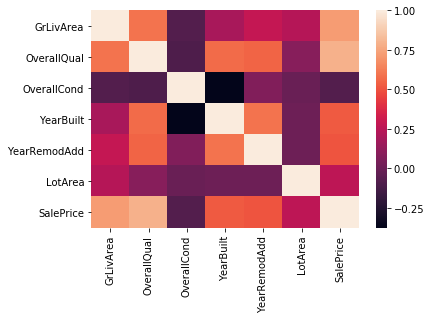

In [15]:
sns.heatmap(correlation)

## Drop columns where most values are missing or with little value

*OverallCond* appears to be fairly meaningless. It's not correlated with  Most properties seem to get a five on the scale from 1 to 10, including the largest, new,  property with an overall quality of 10. Let's drop that variable from our analysis. Doing a little time-travel from the cells further down the page, I can also tell you that dropping this column improves model performance.

In [16]:
train_data = train_data.drop('OverallCond', axis=1)

In [17]:
lots_missing = []

for col in train_data.columns:
    if (len(train_data) - train_data[col].count()) > (.5 * len(train_data)):
        lots_missing.append(col)

In [18]:
lots_missing

['Alley', 'PoolQC', 'Fence', 'MiscFeature']

Okay. There's only a few columns that have over half the values missing. Let's drop those.

In [19]:
train_data = train_data.drop(lots_missing, axis=1)

## Baseline model
Let's make a baseline model with only gross living area square feet to predict the sale price.
Let's fit a linear regression model.

In [20]:
sqft = pd.DataFrame(train_data.loc[:,'GrLivArea'].values.reshape(-1,1), columns=['GrLivArea'])

In [21]:
sqft.describe()

,GrLivArea
count,"1,459.00"
mean,"1,512.64"
std,514.42
min,334.00
25%,"1,129.00"
50%,"1,464.00"
75%,"1,776.00"
max,"4,676.00"


In [22]:
sqft.isnull().any()

GrLivArea    False
dtype: bool

Looks like every property has a value for GrLivArea. Cool. We don't need to cleanup there.

Let's split the data into training and validation sets. Our test set will be excluded from all preprocessing, model selection, and parameter turning so that no information from the test data can leak into the model while it's being built. 

### Training and validation set separation

In [23]:
X_train, X_val, y_train, y_val = train_test_split(sqft, train_data['SalePrice'], test_size = .2, random_state = 34)
b_lr = LinearRegression()             # b for basic
b_lr.fit(X_train, y_train)
predictions = b_lr.predict(X_val)

To evaluate our model we'll use RMSE, or Root Mean Squared Error. RMSE is an ideal scoring metric for a task such as this because it outputs an interpretable value that is in the same units as the target variable: dollars. In the actual Kaggle competition the RMSE of the logarithm of the predicted value and the logarithm of the observed sales price was used for scoring. I find RMSE more intuitive, so that's mostly what I'll be using.

In [24]:
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score = {0:,.0f}".format(rmse))

score = 51,807


### Add more numeric features
Now that we have a baseline let's see if we can reduce the RMSE by adding a few other predictors that are likely to have a large influence on the sale price. We'll fit an OLS  linear regression model again.

In [25]:
five_cols = ['GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'LotArea']
ff_df = train_data.loc[:, five_cols]
print(ff_df.head(3))

   GrLivArea  OverallQual  YearBuilt  YearRemodAdd  LotArea
0       1710            7       2003          2003     8450
1       1262            6       1976          1976     9600
2       1786            7       2001          2002    11250


In [26]:
def make_model(cols):
    """Make linear regression model and print the RMSE.

    Keyword arguments:
    cols -- list of column name features
    """
    X_train, X_val, y_train, y_val = train_test_split(train_data[cols], train_data['SalePrice'], test_size = .2, random_state = 34)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_val)

    score = sqrt(mean_squared_error(y_val, predictions))
    print("Columns: {0} \n score: {1:,.0f}".format(cols, score))
make_model(five_cols)

Columns: ['GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'LotArea'] 
 score: 36,673


RMSE dropped. Cool. We still have a very parsimonious model with 5 features and now we have a much nicer RMSE.

### KNN model
Let's try the same five features with a basic KNN model. Let's make the function to build models more flexible by allowing us to pass the type of model we want built.

In [27]:
def make_model(cols, mod_type):
    """Make a machine learning model and print the RMSE.

    Keyword arguments:
    cols -- list of strings of column name features
    mod_type -- string - sklearn supervised algorithm to use
    """
    X_train, X_val, y_train, y_val = train_test_split(train_data[cols], train_data['SalePrice'], test_size = .2, random_state = 34)
    mod = mod_type
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_val)

    score = sqrt(mean_squared_error(y_val, predictions))
    print(f"Columns: {cols} \n score: {score:,.0f}")


In [28]:
make_model(five_cols, KNeighborsRegressor())

Columns: ['GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'LotArea'] 
 score: 51,980


The KNN model with default parameters  and five features was about the same as the linear regression model with only one feature. We could play with KNN params, but we know KNNs aren't likely to be strong models for this kind of problem, so let's drop that line of inquiry. 


### Gradient Boosting Model

In [29]:
make_model(five_cols, GradientBoostingRegressor())

Columns: ['GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'LotArea'] 
 score: 33,948


That's pretty close to what we saw with the Linear Regression model. We could tune the parameters or we could make some other models but we're getting ahead of ourselves. We have a few basic models to use as baselines. Let's go data cleaning, feature selecting, and feature engineering.

## Separate columns by data type
Let's separate the column types into numeric, ordinal, and nominal data types. For a discussion of data types and why it's helpful to think of them beyond catgorical and numerical see my article [here](https://towardsdatascience.com/7-data-types-a-better-way-to-think-about-data-types-for-machine-learning-939fae99a689).

In [30]:
# make lists of the numerical and string variable categories
numeric_cols = []
string_cols = []    # ordinal and categorical

for col in train_data.columns:
    # True integer or float columns. Continuous, interval data
    if (train_data.dtypes[col] == np.int64 or train_data.dtypes[col] == np.int32 or train_data.dtypes[col] == np.float64):
        numeric_cols.append(col)
    # Nominal and oridnal columns
    if (train_data.dtypes[col] == np.object):  
        string_cols.append(col)

OverallQual is a numeric column, but it contains ordinal data. Similar to a likert scale, it works well to treat it as interval data, I've found, so let's keep it as numeric

In [31]:
y = train_data['SalePrice']
X = train_data.drop(columns=["SalePrice"], axis=1)

In [32]:
'SalePrice' in X

False

In [33]:
# List of ordinal columns
ord_cols = [
"ExterQual",
"ExterCond",
"BsmtQual",
"BsmtCond",
"BsmtExposure",
"BsmtFinType1",
"BsmtFinType2",
"HeatingQC",
"Electrical",
"KitchenQual",
"Functional",
"FireplaceQu",
"GarageQual",
"GarageCond",
"PoolQC",
"Fence"]

Let's split out the nominal columns from the other ordinal columns.

In [34]:
string_data = X[string_cols]
string_data.columns             #includes ordinal columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [35]:
nominal_cols = []

for col in string_data:
    if col not in ord_cols:
        nominal_cols.append(col)

## Status Check
We have the variables grouped into three lists: interval, ordinal, and nominal.

- interval = *numeric_cols*
- ordinal = *ord_cols*
- nominal  = *nominal_cols*

If we need the ordinal and categorical combined, we have all those as string data in *string_cols *

y is the dependent variable (sale price) for the whole non-test set - not broken out into training and validation sets yet

X is the dataframe for the whole non-test set - not broken out into training and validation sets yet

We want to keep track of this carefully.

Let's remove SalePrice from the list of numeric columns.

In [36]:
numeric_cols.remove('SalePrice')

In [37]:
numeric_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

Impute missing values

Before we start filling values, we need to make sure that our testing set data isn't contaminating our imputations, so we'll break the data into training and validation sets. 

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 34)

We have lots of ways we could handle missing values. Fortunately, there aren't many missing values left in our data. Let's fill the missing values for the columns with most freqent values for those columns.

In [39]:
X.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinSF1         0
BsmtFinType2      38
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath     

We don't want to use the validation data in the training data, or else we are cheating. 


In [40]:
X_train = X_train.fillna(X_train.mode().iloc[0])

In [41]:
X_train.isnull().any().any()

False

[This SO answer](https://stackoverflow.com/a/29530303/4590385) had this nifty double .any() to check if any values were NaNs .

Now let's fill the NaNs from the validation set with the most frequent values in the training set.

In [42]:
X_val = X_val.fillna(X_train.mode().iloc[0])

In [43]:
X_val.isnull().any().any()

False

In [44]:
X_train_num = X_train.loc[:, numeric_cols]
X_val_num = X_val.loc[:, numeric_cols]

mod = GradientBoostingRegressor()
mod.fit(X_train_num, y_train)
predictions = mod.predict(X_val_num)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 30,026


## Categorical columns

Ok. Let's convert the string columns to the improved Pandas Category dtype. This will make life easier when we're one-hot (dummy) encoding test set data. First we need to merge the train and test data. Then we'll convert to categorical. Then we'll split back apart into training and test sets.

In [45]:
X_train.shape

(1167, 75)

In [46]:
X_val.shape

(292, 75)

In [47]:
X_again = pd.concat([X_train, X_val])
X_again.shape

(1459, 75)

That looks good. We have 1459 data points in our training and validation datasets combined.

In [48]:
X_again_strings = X_again.select_dtypes(include=object)
X_again_nums = X_again.select_dtypes(include=np.number)
X_again_strings.head() 

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1078,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
502,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,ALQ,GLQ,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,Fa,Fa,Y,WD,Normal
1371,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,Hip,CompShg,AsbShng,AsbShng,None,TA,TA,CBlock,TA,TA,Av,BLQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,BuiltIn,RFn,TA,TA,Y,WD,Normal
639,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,Hip,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,Gd,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,New,Partial
91,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,BrkCmn,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Abnorml


In [49]:
X_again_cats = X_again_strings.astype('category')
X_again_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1078 to 1166
Data columns (total 39 columns):
MSZoning         1459 non-null category
Street           1459 non-null category
LotShape         1459 non-null category
LandContour      1459 non-null category
Utilities        1459 non-null category
LotConfig        1459 non-null category
LandSlope        1459 non-null category
Neighborhood     1459 non-null category
Condition1       1459 non-null category
Condition2       1459 non-null category
BldgType         1459 non-null category
HouseStyle       1459 non-null category
RoofStyle        1459 non-null category
RoofMatl         1459 non-null category
Exterior1st      1459 non-null category
Exterior2nd      1459 non-null category
MasVnrType       1459 non-null category
ExterQual        1459 non-null category
ExterCond        1459 non-null category
Foundation       1459 non-null category
BsmtQual         1459 non-null category
BsmtCond         1459 non-null category
BsmtExposu

Cool. Let's merge them back together.

In [50]:
X_again = X_again_nums.join(X_again_cats)
X_again.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1078,1079,120,37.00,4435,6,2004,2004,169.00,662,0,186,848,848,0,0,848,1,0,1,0,1,1,3,1,"2,004.00",2,420,140,0,0,0,0,0,0,5,2006,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
502,503,20,70.00,9170,5,1965,1965,0.00,698,96,420,1214,1214,0,0,1214,1,0,1,0,2,1,6,0,"1,965.00",2,461,0,0,184,0,0,0,400,4,2007,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,ALQ,GLQ,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,Fa,Fa,Y,WD,Normal
1371,1372,80,80.00,9600,6,1955,1996,0.00,831,0,161,992,1661,0,0,1661,1,0,1,0,3,1,8,1,"1,955.00",1,377,0,28,0,0,178,0,0,10,2008,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,Hip,CompShg,AsbShng,AsbShng,None,TA,TA,CBlock,TA,TA,Av,BLQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,BuiltIn,RFn,TA,TA,Y,WD,Normal
639,640,120,53.00,3982,8,2006,2006,0.00,1154,0,366,1520,1567,0,0,1567,1,0,2,0,1,1,7,1,"2,006.00",3,648,312,0,0,0,0,0,0,10,2006,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,Hip,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,Gd,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,New,Partial
91,92,20,85.00,8500,5,1961,1961,203.00,600,0,635,1235,1235,0,0,1235,0,0,1,0,2,1,6,0,"1,961.00",2,480,0,0,0,0,0,0,0,12,2006,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,BrkCmn,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Abnorml


In [51]:
X_again.shape

(1459, 75)

In [52]:
X_again.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1078 to 1166
Data columns (total 75 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
LotFrontage      1459 non-null float64
LotArea          1459 non-null int64
OverallQual      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
MasVnrArea       1459 non-null float64
BsmtFinSF1       1459 non-null int64
BsmtFinSF2       1459 non-null int64
BsmtUnfSF        1459 non-null int64
TotalBsmtSF      1459 non-null int64
1stFlrSF         1459 non-null int64
2ndFlrSF         1459 non-null int64
LowQualFinSF     1459 non-null int64
GrLivArea        1459 non-null int64
BsmtFullBath     1459 non-null int64
BsmtHalfBath     1459 non-null int64
FullBath         1459 non-null int64
HalfBath         1459 non-null int64
BedroomAbvGr     1459 non-null int64
KitchenAbvGr     1459 non-null int64
TotRmsAbvGrd     1459 non-null int64
Fireplaces       1459 non-null int6

Great. Now let's re-separate the training and validation sets.

In [53]:
X_train = X_again.iloc[:1167, :]
X_val = X_again.iloc[1167:, :]

In [54]:
X_train.shape

(1167, 75)

In [55]:
X_val.shape

(292, 75)

Okay. We're back to our split training and validation datasets.

### GBRT
Let's try a GradientBoostingRegressor() to see how it performs with all the numeric features prior to one-hot-encoding ordinal and nominal data and prior to transforming data.

In [56]:
X_train_num = X_train.loc[:, numeric_cols]
X_val_num = X_val.loc[:, numeric_cols]

mod = GradientBoostingRegressor(random_state=34)
mod.fit(X_train_num, y_train)
predictions = mod.predict(X_val_num)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

predictions[:5]

score: 29,258


array([111888.83271476,  96428.28108898, 138197.21772485,  95459.90683056,
       367917.5856053 ])

Ok. Those predictions look reasonable.

Our RMSE dropped a bit. That's our best score yet.

## Dummy-encode nominal and ordinal variables.
Let's one-hot (dummy) encode the categorical (nominal and ordinal) data with pd.get_dummies. 

In [57]:
X_train.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
1078,1079,120,37.00,4435,6,2004,2004,169.00,662,0,186,848,848,0,0,848,1,0,1,0,1,1,3,1,"2,004.00",2,420,140,0,0,0,0,0,0,5,2006,RM,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,TwnhsE,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,RFn,TA,TA,Y,WD,Normal
502,503,20,70.00,9170,5,1965,1965,0.00,698,96,420,1214,1214,0,0,1214,1,0,1,0,2,1,6,0,"1,965.00",2,461,0,0,184,0,0,0,400,4,2007,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,TA,TA,No,ALQ,GLQ,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Detchd,Unf,Fa,Fa,Y,WD,Normal
1371,1372,80,80.00,9600,6,1955,1996,0.00,831,0,161,992,1661,0,0,1661,1,0,1,0,3,1,8,1,"1,955.00",1,377,0,28,0,0,178,0,0,10,2008,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,SLvl,Hip,CompShg,AsbShng,AsbShng,None,TA,TA,CBlock,TA,TA,Av,BLQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,TA,BuiltIn,RFn,TA,TA,Y,WD,Normal
639,640,120,53.00,3982,8,2006,2006,0.00,1154,0,366,1520,1567,0,0,1567,1,0,2,0,1,1,7,1,"2,006.00",3,648,312,0,0,0,0,0,0,10,2006,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Blmngtn,Norm,Norm,TwnhsE,1Story,Hip,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,Gd,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,New,Partial
91,92,20,85.00,8500,5,1961,1961,203.00,600,0,635,1235,1235,0,0,1235,0,0,1,0,2,1,6,0,"1,961.00",2,480,0,0,0,0,0,0,0,12,2006,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,HdBoard,HdBoard,BrkCmn,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,TA,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Abnorml


In [58]:
len(X_train.columns)

75

pd.get_dummies will convert all categorical data to one-hot-encoded columns. 

In [59]:
X_train_dummies = pd.get_dummies(X_train)
X_train_dummies.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_G

In [60]:
len(X_train_dummies.columns)

274

That added about 200 features.

In [61]:
X_val_dummies = pd.get_dummies(X_val).reindex(columns=X_train_dummies.columns, fill_value=0)
X_val_dummies.isna().any().any()

False

In [62]:
X_train_dummies.isna().any().any()

False

In [63]:
mod = GradientBoostingRegressor()
mod.fit(X_train_dummies, y_train)
predictions = mod.predict(X_val_dummies)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 27,724


Alright. Our score continues to improve.  How does an OLS regression model do?

In [64]:
mod = LinearRegression(normalize=True)
mod.fit(X_train_dummies, y_train)
predictions = mod.predict(X_val_dummies)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 71,990,857,032,065,584


Wow. Not well. It's probably getting overwhelmed by the dimensionality, while the GBRT doesn't. Let's try it with just the first 20 features.

In [65]:
X_train_cols = X_train_dummies.iloc[:, :20]
X_val_cols = X_val_dummies.iloc[:, :20]

mod = LinearRegression(normalize=True)
mod.fit(X_train_cols, y_train)
predictions = mod.predict(X_val_cols)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 32,487


Yep. Just keeping the first 20 columns the model does much better. Let's find out where the model goes haywire.

In [66]:
X_train_cols = X_train_dummies.iloc[:, :50]
X_val_cols = X_val_dummies.iloc[:, :50]

mod = LinearRegression(normalize=True)
mod.fit(X_train_cols, y_train)
predictions = mod.predict(X_val_cols)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 30,370


Ok at 50 features.

In [67]:
X_train_cols = X_train_dummies.iloc[:, :102]
X_val_cols = X_val_dummies.iloc[:, :102]

mod = LinearRegression(normalize=True)
mod.fit(X_train_cols, y_train)
predictions = mod.predict(X_val_cols)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 36,665


A little worse at 102 features, but not crazy.

In [68]:
X_train_cols = X_train_dummies.iloc[:, :103]
X_val_cols = X_val_dummies.iloc[:, :103]

mod = LinearRegression(normalize=True)
mod.fit(X_train_cols, y_train)
predictions = mod.predict(X_val_cols)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 21,648,333,133,961,392


Wow! The difference in RMSE between the regression model with the first 102 features and the first 103 features is huge!

In [69]:
X_train_cols.iloc[:, :103].columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery',
       'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA',
       'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn',
       'Condition2_RRNn'],
      dtype='object', length=103)

Looks like that feature is just the one that broke the models back. 

Let's do some feature scaling and then some feature selection to improve performance.

## Scaling
Scaling is important for some machine learning algorithms, including regression-based models, KNNs Kernel SVMs, and Neural Nets. [Here's a Kernel](https://www.kaggle.com/discdiver/scale-standardize-or-normalize-with-sklearn) I made explaining the differences between scaling, standardizing, and normalizing with sklearn.

We'll use MinMaxScaler() to scale the features from zero to one. This is the most gentle scaler. It doesn't reduce the distance between the values; it's not a tranformation. However, it should help models that need similarly-scaled inputs perform better.

First we'll make the DataFrame names nicer for our training data. They are getting a bit long.

In [70]:
X_t = X_train_dummies
X_v = X_val_dummies

Then we'll scale the training and validation sets

In [71]:
scaler = MinMaxScaler()
cols = X_t.columns

X_t = scaler.fit_transform(X_t)
X_v = scaler.transform(X_v)

X_t = pd.DataFrame(X_t, columns=cols)
X_v = pd.DataFrame(X_v, columns=cols)
X_t.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_G

In [72]:
mod = LinearRegression()
mod.fit(X_t, y_train)
predictions = mod.predict(X_v)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 108,574,259,886,861


Woah! Not good for Linear Regression. 

# Feature Selection

We should do some feature elimination if we want to improve it. Let's use recursive feature elimination with a Linear Regression model to choose our features. We'll keep 40 features.

In [73]:
lr = LinearRegression(normalize=True)
lr.fit(X_t, y_train)
rfe = RFE(lr, n_features_to_select=40)
rfe.fit(X_t,y_train)
keep = rfe.fit(X_t, y_train)

keep.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,

*support_* shows us which features will be kept, but let's map this boolean array to the DataFrame columns.

In [74]:
X_train_keep = X_t.loc[:, keep.support_.ravel()]

In [75]:
X_train_keep.head()

,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,Exterior1st_CBlock,Exterior2nd_CBlock,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_Mix,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
4,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00


In [76]:
X_train_keep.columns

Index(['RoofMatl_CompShg', 'RoofMatl_Membran', 'RoofMatl_Metal',
       'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake',
       'Exterior1st_CBlock', 'Exterior2nd_CBlock', 'BsmtCond_Fa',
       'BsmtCond_Gd', 'BsmtCond_Po', 'BsmtCond_TA', 'Heating_Floor',
       'Heating_GasA', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW',
       'Heating_Wall', 'Electrical_Mix', 'Functional_Maj1', 'Functional_Maj2',
       'Functional_Min1', 'Functional_Min2', 'Functional_Mod',
       'Functional_Sev', 'Functional_Typ', 'FireplaceQu_Ex', 'FireplaceQu_Fa',
       'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'PavedDrive_N',
       'PavedDrive_P', 'PavedDrive_Y', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial'],
      dtype='object')

This looks strange. The columns that were selected are not the ones you'd expect. Let's see what a regression model does. First we'll slice the validation dataset so it has the same columns as the training dataset. Then we'll fit a regression model.

In [77]:
cols = X_train_keep.columns
X_val_keep = X_v.loc[:, cols]

In [78]:
mod = LinearRegression()
mod.fit(X_train_keep, y_train)
predictions = mod.predict(X_val_keep)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 271,228,319,760,396,544


That score is garbage. It makes sense that linear regression on the full features set wouldn't work well for feature elimination if it didn't work well for general prediction. 

Let's use a different algorithm for feature selection. Let's take the most important feature importances as determined by our best model so far, the GBRT.

## GBRT again

Let's look at a GBRT model again.

In [79]:
mod = GradientBoostingRegressor(max_features=42, random_state=34)
mod.fit(X_t, y_train)
predictions = mod.predict(X_v)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 27,763


40-45 features seems to result in the best model. 

Let's look at the feature importances.

In [80]:
important_features = pd.Series(data=mod.feature_importances_,index=X_t.columns)
important_features.sort_values(ascending=False,inplace=True)

Let's plot the top 20.

GrLivArea          0.15
GarageCars         0.12
OverallQual        0.11
ExterQual_TA       0.10
BsmtQual_Ex        0.06
1stFlrSF           0.05
GarageArea         0.03
TotalBsmtSF        0.03
BsmtFinSF1         0.03
YearBuilt          0.03
TotRmsAbvGrd       0.02
FullBath           0.02
Fireplaces         0.02
LotArea            0.02
MasVnrArea         0.02
2ndFlrSF           0.02
BsmtFinType1_GLQ   0.02
GarageFinish_Unf   0.02
ExterQual_Ex       0.01
KitchenQual_Ex     0.01
dtype: float64


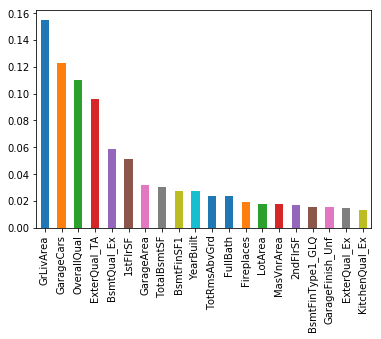

In [81]:
print(important_features[:20])
important_features[:20].plot(kind='bar')

This looks pretty reasonable. The overall sqft of the house matters most. Then how man cars fit in the garage. Then then some info on the quality. Then some square footage. Let's see what a regression model does with just those 45 features.

In [82]:
type(important_features)

pandas.core.series.Series

In [83]:
important_features = important_features[:45]

In [84]:
gbrt_features = list(important_features.index.values) 

In [85]:
X_train_small = X_t.loc[:, gbrt_features] 
X_val_small = X_v.loc[:, gbrt_features]

In [86]:
mod = LinearRegression()
mod.fit(X_train_small, y_train)
predictions = mod.predict(X_val_small)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 29,419


The regression model, cracks 30k! That looks much better. Feature selection can have big benefits for linear regression. 

Let's explore some other models with gridsearchCV and pipelines.

## Pipeline and gridsearch 

Let's test multiple models and tune hyperparameters. 

In [87]:
pipe = Pipeline([
    ('preprocessing', MinMaxScaler()),
    ('regressor', GradientBoostingRegressor())
])

In [88]:
params = [
    {
        'regressor': [GradientBoostingRegressor(random_state=34)], 'preprocessing': [None],
        'regressor__max_depth': [3, 5, 7],
        'regressor__max_leaf_nodes': [10, 100, None]
    },
    { 
        'regressor': [Ridge()],'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .01, .1, 1, 10, 100]
    }
]

In [89]:
grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_t, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', MinMaxScaler(copy=True, feature_range=(0, 1))), ('regressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
   ...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'regressor': [GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=10, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
       ...ler(copy=True, with_mean=True, with_std=True)], 'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit

In [90]:
print(f'Best params:{grid.best_params_}')
print(f'Best cross-val score: {grid.best_score_}')
print(f'Validation set score: {grid.score(X_v, y_val)}')

Best params:{'preprocessing': None, 'regressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=10, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=34, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False), 'regressor__max_depth': 7, 'regressor__max_leaf_nodes': 10}
Best cross-val score: 0.8710533443358629
Validation set score: 0.8868154657453844


This outputs the default score, r squared. Looks like a GBRT model has the best score (higher is better). R squared captures how much variance the model accounts for for. Let's look at the error in terms of RMSE.

In [91]:
grid = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_t, y_train)
print(f'Best params: {grid.best_params_}')

# training set scores
print(f'Best cross-val score: {grid.best_score_}')
rmse = sqrt(-grid.best_score_)
print(f'Best cross-val score rmse: {rmse}')

# validation set scores
print(f'Validation set score: {grid.score(X_v, y_val)}')

rm = sqrt(-grid.score(X_v, y_val))
print(f'Val score set score rmse: {rm}')

Best params: {'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor': Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'regressor__alpha': 100}
Best cross-val score: -802841627.5740775
Best cross-val score rmse: 28334.460072040856
Validation set score: -1128914645.4405556
Val score set score rmse: 33599.325074182


**A few things to note:** 

Interesting. A Ridge model scores best with negative mean squared error as the scoring (and refitting) metric.

Note that these models don't have a reduced feature set.

The cross-val score hasn't improved from the best previous untuned GBRT had, but the GBRT was without cross-validation. 

What happens if we don't tune the GBRT and test it with cross validation?

In [92]:
params = [
    {
        'regressor': [GradientBoostingRegressor(random_state=34)], 'preprocessing': [None],
       # 'regressor__max_depth': [3, 5, 7],
       # 'regressor__max_leaf_nodes': [10, 100, None]
    },
    { 
       # 'regressor': [Ridge()],'preprocessing': [StandardScaler()],
       # 'regressor__alpha': [0.001, .01, .1, 1, 10, 100]
    }
]

grid = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_t, y_train)
print(f'Best params:{grid.best_params_}')

# training set scores
print(f'Best cross-val score: {grid.best_score_}')
rmse = sqrt(-grid.best_score_)
print(f'Best cross-val score rmse: {rmse}')

# validation set scores
print(f'Validation set score: {grid.score(X_v, y_val)}')

rm = sqrt(-grid.score(X_v, y_val))
print(f'Val score set score rmse: {rm}')

Best params:{}
Best cross-val score: -863269195.5656363
Best cross-val score rmse: 29381.443047706765
Validation set score: -763928516.1124889
Val score set score rmse: 27639.256793779547


Interesting. GBRT performs markedly better than Ridge. Our parameter grid was just limiting GBRT's performance. The defaults are better than the search grid ranges. Let's expand the hyperparameter ranges.

In [93]:
params = [{
    'regressor': [GradientBoostingRegressor(random_state=34)], 'preprocessing': [None],
    'regressor__max_depth': [7, 20],
    'regressor__max_leaf_nodes': [10, 100, None],
    'regressor__max_features': [1, 2],
    'regressor__min_samples_leaf': [3, 5],
    'regressor__min_samples_split': [2, 5],
    'regressor__n_estimators': [100, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
}]
    
grid = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_t, y_train)
print(f'Best params:{grid.best_params_}')

# training set scores
print(f'Best cross-val score:{grid.best_score_}')
rmse = sqrt(-grid.best_score_)
print(f'Best cross-val score rmse:{rmse}')

# validation set scores
print(f'Validation set score{grid.score(X_v, y_val)}')

rm = sqrt(-grid.score(X_v, y_val))
print(f'Val score set score rmse:{rm}')


Best params:{'preprocessing': None, 'regressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=20, max_features=2,
             max_leaf_nodes=10, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=300, n_iter_no_change=None, presort='auto',
             random_state=34, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False), 'regressor__learning_rate': 0.05, 'regressor__max_depth': 20, 'regressor__max_features': 2, 'regressor__max_leaf_nodes': 10, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best cross-val score:-837517968.359378
Best cross-val score rmse:28939.90270127697
Validation set score-1020486943.6540786
Val score set score rmse:31945.061334329577


Looks like we're overfitting a bit compared to the default parameters. Let's just keep the default parameters for now.

Let's change the scorer so that it outputs multiple scores. Here's the list of built-in scorers.

In [94]:
from sklearn.metrics import SCORERS
sorted(SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [95]:
scorers = {
    'r2': 'r2',
    'nmsle': 'neg_mean_squared_log_error',
    'nmse': 'neg_mean_squared_error'
}

params = [
    {
        'regressor': [GradientBoostingRegressor(random_state=34)], 'preprocessing': [None],
    }
]

grid = GridSearchCV(pipe, params, cv=5, scoring=scorers, refit='nmse')
grid.fit(X_t, y_train)
print(f'Best params:{grid.best_params_}')
print(f'Best cross-val score:{grid.best_score_}')
print(f'Validation set score{grid.score(X_v, y_val)}')

rm = sqrt(-grid.score(X_v, y_val))
print(f'Val score set score rmse: {rm}')

print(str(grid.cv_results_['mean_test_r2']))
print(str(grid.cv_results_['mean_test_nmsle']))
print(str(grid.cv_results_['mean_test_nmse']))

rm = sqrt(-grid.cv_results_['mean_test_nmse'])
print(f'Val set rmse: {rm}')

Best params:{'preprocessing': None, 'regressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=34, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)}
Best cross-val score:-871978965.3235902
Validation set score-770165532.4958034
Val score set score rmse: 27751.85637927314
[0.86242852]
[-0.01816306]
[-8.71978965e+08]
Val set rmse: 29529.28995630593


### Lasso, Ridge, and KernelRidge

Let's expand our models and parameter grids. We'll fit Lasso, Ridge, and KernelRidge models after scaling the features. We'll search over several levels of regularization. Alpha provides L2 regularization in the case of Ridge and KernelRidge and L1 regularization in the case of Lasso. 

In [96]:

params = [
    { 
        'regressor': [Ridge()], 'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .1, 1, 10, 100]
    },
    { 
        'regressor': [Lasso()], 'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .1, 1, 10, 100]
    },
    {
        'regressor': [KernelRidge()], 'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .1, 1, 10, 100]
    },
]

grid = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_squared_error', refit='nmse')
grid.fit(X_t, y_train)
print(f'Best params:{grid.best_params_}')
print(f'Best cross-val score:{grid.best_score_}')

# validation set scores
print(f'Validation set score: {grid.score(X_v, y_val)}')

rm = sqrt(-grid.score(X_v, y_val))
print(f'Val score set score rmse: {rm}')

Best params:{'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor': Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'regressor__alpha': 100}
Best cross-val score:-802841627.5740775
Validation set score: -1128914645.4405556
Val score set score rmse: 33599.325074182


Let's see what happens if we use the smaller set of features we used earlier.

In [97]:
params = [
    { 
        'regressor': [Ridge()], 'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .1, 1, 10, 100]
    },
    { 
        'regressor': [Lasso()], 'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .1, 1, 10, 100]
    },
    {
        'regressor': [KernelRidge()], 'preprocessing': [StandardScaler()],
        'regressor__alpha': [0.001, .1, 1, 10, 100]
    },
]

grid = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_squared_error', refit='nmse')
grid.fit(X_train_small, y_train)
print(f'Best params:{grid.best_params_}')
print(f'Best cross-val score: {grid.best_score_}')

# validation set scores
print(f'Validation set score: {grid.score(X_val_small, y_val)}')

rm = sqrt(-grid.score(X_val_small, y_val))
print(f'Val score set score rmse: {rm}')

Best params:{'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'regressor': Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), 'regressor__alpha': 100}
Best cross-val score: -858016650.9584885
Validation set score: -839631144.7013664
Val score set score rmse: 28976.389435217192


Alright. Not bad. Ridge is tops with *alpha=100*. Let's try some additional model types.

### SVM & KNN

Let's try a Suport Vector Machine. SVR(kernel='RBF') is what we want. We'll just try it with mostly default params and if it is way off, we won't pursue it.

In [98]:
mod = SVR(kernel='rbf')
mod.fit(X_t, y_train)
predictions = mod.predict(X_v)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 85,587


RMSE of 85k. That's not so hot.

Let's try the SVM with the top 45 features.

In [99]:
mod = SVR(kernel='rbf')
mod.fit(X_train_small, y_train)
predictions = mod.predict(X_val_small)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 85,566


That's about the same score. Alright, let's revisit the KNN model from earlier with the smaller feature set.

In [100]:
mod = KNeighborsRegressor()
mod.fit(X_train_small, y_train)
predictions = mod.predict(X_val_small)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 42,634


That score isn't toward the top, but it's better than the SVM models. Let's move on to another boosting model.

### XGBoost

Let's try the powerful XGBoost model. First, we'll use some default parameters and we'll increase the estimators.

In [101]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=100,                                                                    
    subsample=0.8,
    random_state=34) 

In [102]:
mod.fit(X_t, y_train)
predictions = mod.predict(X_v)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 82,084


Not so hot, but the number of estimators is low. Let's up it to 1,000.

In [103]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=1000,                                                                    
    subsample=0.8,
    random_state=34) 

In [104]:
mod.fit(X_t, y_train)
predictions = mod.predict(X_v)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 26,681


That's right at the level of the best models. Now let's try 10,000 estimators.

In [105]:
mod = xgb.XGBRegressor(
    gamma=1,                 
    learning_rate=0.01,
    max_depth=3,
    n_estimators=10000,                                                                    
    subsample=0.8,
    random_state=34
) 

In [106]:
mod.fit(X_t, y_train)
predictions = mod.predict(X_v)
rmse = sqrt(mean_squared_error(y_val, predictions))
print("score: {0:,.0f}".format(rmse))

score: 25,669


As expected, the model takes more time to run with more estimators - and we didn't K-folds cross validate. But the score is the best yet. 

# Conclusion

In this project we've evaluated a number of different types of models. As is often the case, a decision tree boosting ensemble method performed the best. But the work of a data scientist is never done. Here are some future areas for exploration.

# Future directions

### Time series
This data spans five years. There might be a trend and/or seasonality in the sales. Exponential smoothing (Holt-Winters) or SARIMA could be used to try to improve the models.

### Feature engineering
Could try binning or combining features. 

### Feature encoding
Could also try encoding nominal and ordinal features with other encoders, as I discuss in [this article](https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159).

### Model stacking
Stacking models could be fun.

### Other models
Always an option. Might look at two other boosting models in the future: LightGBM and CatBoost.

### More parameter tuning
Also always an option. Would probably make the most sense to do with the XGBoost model, as it is currently the best performing.


In this example we've done a top to bottom regression project to predict housing prices. We explored, cleaned and prepared our models. We created a good number of models with pipelines and searched over those models and  hyperparameters with a grid search. We ended up with a model that predicts sales prices fairly well.
